In [2]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import torch
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
from omegaconf import OmegaConf

from brainage.model.model3d import AgeModel3DVolume
from brainage.dataset.dataset3d import BrainPatchDataset

In [14]:
cfg = OmegaConf.load('../../config/patchwise/dataset/hr.yaml')
cfg.dataset
data_path = cfg.dataset.data
data_group = cfg.dataset.group
info = cfg.dataset.info
infocolumn = cfg.dataset.column
val_set = cfg.dataset.val
patch_size = cfg.dataset.patch_size

val_keys = [l.strip() for l in Path(val_set).open().readlines()]

In [15]:
ds_test = BrainPatchDataset(data=data_path,
                            keys=val_keys[:5], 
                            info=info,
                            column=infocolumn,
                            patch_size=patch_size,
                            group=data_group,
                            preload=True,
                            transform=None) 

100%|██████████| 5/5 [00:01<00:00,  4.57it/s]


In [17]:
# small patches
#ckpt = '/home/raheppt1/projects/brainage/outputs/brainage/patchwise/2020-09-07/12-18-11/brainage/3shtbtf4/checkpoints/epoch=241.ckpt'
# large patches
ckpt = '/home/raheppt1/projects/brainage/outputs/brainage/patchwise/2020-08-30/20-18-46/0/brainage/301f9tu6/checkpoints/epoch=243.ckpt'
model = AgeModel3DVolume.load_from_checkpoint(ckpt, train_ds=None, val_ds=None)
model.eval()

AgeModel3DVolume(
  (loss_criterion): l2_loss()
  (net): ResNet(
    (conv1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
    (bn1): VarNorm3d(
      (layer): InstanceNorm3d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    )
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer3): Sequential(
      (0): BasicBlock(
        (conv1): Conv3d(64, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (bn1): VarNorm3d(
          (layer): InstanceNorm3d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        )
        (relu): ReLU(inplace=True)
        (conv2): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (bn2): VarNorm3d(
          (layer): InstanceNorm3d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        )
        (d

In [26]:
idx = 3
sample = ds_test[idx]

# prediction
input = torch.tensor(sample['data'][np.newaxis, ...]).float()
position = torch.tensor(sample['position']).float()
label = sample['label']
y = model(input, hook=True)
# compute gradients
y[:,0].backward()
gradients = model.net.get_activations_gradient()
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
activations = model.net.get_activations(input).detach()
print(y, label)

tensor([[39.6392,  1.9037]], grad_fn=<AddmmBackward>) 45.0


In [30]:
# weight the channels by corresponding gradients
for i in range(activations.size()[1]):
    activations[:, i, :, :] *= pooled_gradients[i]
# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()
# normalize the heatmap
heatmap /= torch.max(heatmap)
# resample heatmap
hmap = heatmap.squeeze().numpy()
img = sample['data'][0]
zoom = np.array(img.shape)/np.array(hmap.shape)
heatmap_zoomed = scipy.ndimage.zoom(hmap, zoom, order=3)
print(heatmap.numpy().shape, heatmap_zoomed.shape)
heatmap_max = heatmap_zoomed.max()
heatmap_min = heatmap_zoomed.min()
print(heatmap_min, heatmap_max)

(32, 32, 32) (64, 64, 64)
0.008031361 1.0340476


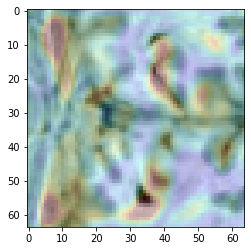

In [32]:
plt.imshow(sample['data'][0, :,5,:].astype(np.float32), cmap='gray')
plt.imshow(heatmap_zoomed[ :,5,:], alpha=0.2, cmap='jet', vmin=0.0, vmax=heatmap_max*0.2)

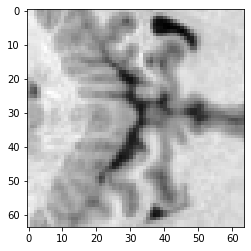

In [33]:
plt.imshow(sample['data'][0, :,24,:].astype(np.float32), cmap='gray')


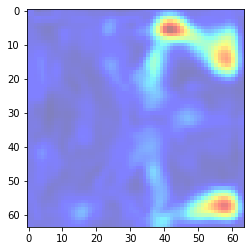

In [34]:
plt.imshow(heatmap_zoomed[ :,24,:], alpha=0.5, cmap='jet')

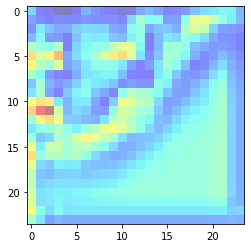

In [13]:
plt.imshow(heatmap[ :,3,:], alpha=0.5, cmap='jet')